# Chapter 9 - Data Science

## 0 - Setting up the notebook

In [1]:
import json
import calendar
import random
from datetime import date, timedelta
import faker
import numpy as np
from pandas import DataFrame
from delorean import parse
import pandas as pd
# make the graphs nicer
pd.set_option('display.mpl_style', 'default')

## 1 - Preparing the Data

In [2]:
# create the faker to populate the data
fake = faker.Faker()

In [3]:
usernames = set()
usernames_no = 1000

# populate the set with 1000 unique usernames
while len(usernames) < usernames_no:
    usernames.add(fake.user_name())

In [4]:
def get_random_name_and_gender():
    skew = .6  # 60% of users will be female
    male = random.random() > skew
    if male:
        return fake.name_male(), 'M'
    else:
        return fake.name_female(), 'F'

# for each username, create a complete user profile
# simulate user data coming from an API. It is a list
# of JSON strings (users).
def get_users(usernames):
    users = []
    for username in usernames:
        name, gender = get_random_name_and_gender()
        user = {
            'username': username,
            'name': name,
            'gender': gender,
            'email': fake.email(),
            'age': fake.random_int(min=18, max=90),
            'address': fake.address(),
        }
        users.append(json.dumps(user))
    return users

users = get_users(usernames)
users[:3]

['{"gender": "M", "email": "kovacek.harlow@tromp.com", "age": 67, "address": "62545 Boehm Roads Suite 203\\nTeressaburgh, MO 05361-8033", "username": "lovina.ward", "name": "Dr. Dashawn Bode DVM"}',
 '{"gender": "M", "email": "loriann30@herzogbernier.info", "age": 52, "address": "51777 Green Wells\\nWest Demian, WV 92185-1680", "username": "langosh.carlota", "name": "Chas Hauck"}',
 '{"gender": "F", "email": "romaguera.teagan@gmail.com", "age": 63, "address": "633 Webb Curve Suite 621\\nWest Stephen, NE 37790-5314", "username": "zklocko", "name": "Elzada Ullrich"}']

In [5]:
# campaign name format:
# InternalType_StartDate_EndDate_TargetAge_TargetGender_Currency
def get_type():
    # just some gibberish internal codes
    types = ['AKX', 'BYU', 'GRZ', 'KTR']
    return random.choice(types)

def get_start_end_dates():
    duration = random.randint(1, 2 * 365)
    offset = random.randint(-365, 365)
    start = date.today() - timedelta(days=offset)
    end = start + timedelta(days=duration)
    
    def _format_date(date_):
        return date_.strftime("%Y%m%d")
    
    return _format_date(start), _format_date(end)

def get_age():
    age = random.randint(20, 45)
    age -= age % 5
    diff = random.randint(5, 25)
    diff -= diff % 5
    return '{}-{}'.format(age, age + diff)

def get_gender():
    return random.choice(('M', 'F', 'B'))

def get_currency():
    return random.choice(('GBP', 'EUR', 'USD'))

def get_campaign_name():
    separator = '_'
    type_ = get_type()
    start_end = separator.join(get_start_end_dates())
    age = get_age()
    gender = get_gender()
    currency = get_currency()
    return separator.join(
        (type_, start_end, age, gender, currency))

In [6]:
# campaign data:
# name, budget, spent, clicks, impressions
def get_campaign_data():
    name = get_campaign_name()
    budget = random.randint(10**3, 10**6)
    spent = random.randint(10**2, budget)    
    clicks = int(random.triangular(10**2, 10**5, 0.2 * 10**5))    
    impressions = int(random.gauss(0.5 * 10**6, 2))
    return {
        'cmp_name': name,
        'cmp_bgt': budget,
        'cmp_spent': spent,
        'cmp_clicks': clicks,
        'cmp_impr': impressions
    }

In [7]:
# assemble the logic to get the final version of the rough data
# data will be a list of dictionaries. Each dictionary will follow
# this structure:
# {'user': user_json, 'campaigns': [c1, c2, ...]}
# where user_json is the JSON string version of a user data dict
# and c1, c2, ... are campaign dicts as returned by
# get_campaign_data

def get_data(users):
    data = []
    for user in users:
        campaigns = [get_campaign_data()
                     for _ in range(random.randint(2, 8))]
        data.append({'user': user, 'campaigns': campaigns})
    return data

## 2 - Cleaning the data

In [8]:
# fetch simulated rough data
rough_data = get_data(users)

rough_data[:2]  # let's take a peek

[{'campaigns': [{'cmp_bgt': 216573,
    'cmp_clicks': 20560,
    'cmp_impr': 500001,
    'cmp_name': 'KTR_20151211_20170827_35-50_M_EUR',
    'cmp_spent': 78709},
   {'cmp_bgt': 592686,
    'cmp_clicks': 9723,
    'cmp_impr': 499998,
    'cmp_name': 'GRZ_20150911_20170907_35-60_M_GBP',
    'cmp_spent': 315566},
   {'cmp_bgt': 835748,
    'cmp_clicks': 59250,
    'cmp_impr': 500001,
    'cmp_name': 'BYU_20160114_20170119_25-45_B_EUR',
    'cmp_spent': 460611},
   {'cmp_bgt': 243361,
    'cmp_clicks': 34327,
    'cmp_impr': 500001,
    'cmp_name': 'BYU_20150623_20160504_35-55_F_EUR',
    'cmp_spent': 199229}],
  'user': '{"gender": "M", "email": "kovacek.harlow@tromp.com", "age": 67, "address": "62545 Boehm Roads Suite 203\\nTeressaburgh, MO 05361-8033", "username": "lovina.ward", "name": "Dr. Dashawn Bode DVM"}'},
 {'campaigns': [{'cmp_bgt': 535539,
    'cmp_clicks': 80463,
    'cmp_impr': 500003,
    'cmp_name': 'GRZ_20141208_20141210_40-50_F_GBP',
    'cmp_spent': 268086},
   {'cmp_bg

In [9]:
# Let's start from having a different version of the data
# I want a list whose items will be dicts. Each dict is 
# the original campaign dict plus the user JSON

data = []
for datum in rough_data:
    for campaign in datum['campaigns']:
        campaign.update({'user': datum['user']})
        data.append(campaign)
data[:2]  # let's take another peek

[{'cmp_bgt': 216573,
  'cmp_clicks': 20560,
  'cmp_impr': 500001,
  'cmp_name': 'KTR_20151211_20170827_35-50_M_EUR',
  'cmp_spent': 78709,
  'user': '{"gender": "M", "email": "kovacek.harlow@tromp.com", "age": 67, "address": "62545 Boehm Roads Suite 203\\nTeressaburgh, MO 05361-8033", "username": "lovina.ward", "name": "Dr. Dashawn Bode DVM"}'},
 {'cmp_bgt': 592686,
  'cmp_clicks': 9723,
  'cmp_impr': 499998,
  'cmp_name': 'GRZ_20150911_20170907_35-60_M_GBP',
  'cmp_spent': 315566,
  'user': '{"gender": "M", "email": "kovacek.harlow@tromp.com", "age": 67, "address": "62545 Boehm Roads Suite 203\\nTeressaburgh, MO 05361-8033", "username": "lovina.ward", "name": "Dr. Dashawn Bode DVM"}'}]

### Creating the DataFrame

In [10]:
# data is good enough for creating an initial DataFrame
df = DataFrame(data)

# let's take a peek at the first 5 rows, to make sure
# nothing weird has happened
df.head()

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
0,216573,20560,500001,KTR_20151211_20170827_35-50_M_EUR,78709,"{""gender"": ""M"", ""email"": ""kovacek.harlow@tromp..."
1,592686,9723,499998,GRZ_20150911_20170907_35-60_M_GBP,315566,"{""gender"": ""M"", ""email"": ""kovacek.harlow@tromp..."
2,835748,59250,500001,BYU_20160114_20170119_25-45_B_EUR,460611,"{""gender"": ""M"", ""email"": ""kovacek.harlow@tromp..."
3,243361,34327,500001,BYU_20150623_20160504_35-55_F_EUR,199229,"{""gender"": ""M"", ""email"": ""kovacek.harlow@tromp..."
4,535539,80463,500003,GRZ_20141208_20141210_40-50_F_GBP,268086,"{""gender"": ""M"", ""email"": ""loriann30@herzogbern..."


In [11]:
# OK! DataFrame is alive and well!
# let's get a sense of how many rows there are and what is
# their structure.
df.count()

cmp_bgt       4965
cmp_clicks    4965
cmp_impr      4965
cmp_name      4965
cmp_spent     4965
user          4965
dtype: int64

In [12]:
df.describe()

,cmp_bgt,cmp_clicks,cmp_impr,cmp_spent
count,4965.000000,4965.000000,4965.000000,4965.000000
mean,494768.809668,40243.924270,499999.504532,248895.367976
std,287044.587493,21407.518401,2.007402,219199.951460
min,1486.000000,849.000000,499993.000000,116.000000
25%,244372.000000,23067.000000,499998.000000,66705.000000
50%,491591.000000,37072.000000,499999.000000,182525.000000
75%,741778.000000,55008.000000,500001.000000,384621.000000
max,999804.000000,99674.000000,500006.000000,976105.000000


In [13]:
# let's see which are the top and bottom 3 campaigns according
# to budget (regardless of the currency)
df.sort_index(by=['cmp_bgt'], ascending=False).head(3)

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
4305,999804,29225,499999,BYU_20160728_20170605_25-30_B_GBP,355175,"{""gender"": ""F"", ""email"": ""oprice@hotmail.com"",..."
1868,999740,64365,499999,BYU_20150116_20150609_35-40_M_GBP,340233,"{""gender"": ""M"", ""email"": ""idaniel@wisozk.com"",..."
1184,999570,31774,499998,KTR_20151211_20160722_40-55_B_EUR,411366,"{""gender"": ""F"", ""email"": ""derrell.nitzsche@klo..."


In [14]:
df.sort_index(by=['cmp_bgt'], ascending=False).tail(3)

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
3217,1646,43401,499998,BYU_20160819_20160830_35-40_F_GBP,372,"{""gender"": ""M"", ""email"": ""damon.jenkins@gmail...."
1805,1607,28353,499998,KTR_20151202_20160519_40-50_M_GBP,595,"{""gender"": ""F"", ""email"": ""felicia72@gmail.com""..."
1942,1486,43493,500000,GRZ_20150930_20160114_20-40_F_EUR,288,"{""gender"": ""M"", ""email"": ""parisian.kiara@gmail..."


## 3 - Manipulating the DataFrame

In [15]:
# first, let's explode cmp_name into its components
# and get a separate DataFrame for those

def unpack_campaign_name(name):
    # very optimistic method, assumes data in campaign name
    # is always in good state
    type_, start, end, age, gender, currency = name.split('_')
    start = parse(start).date
    end = parse(end).date
    return type_, start, end, age, gender, currency

campaign_data = df['cmp_name'].apply(unpack_campaign_name)
campaign_cols = [
    'Type', 'Start', 'End', 'Age', 'Gender', 'Currency']
campaign_df = DataFrame(
    campaign_data.tolist(), columns=campaign_cols, index=df.index)
campaign_df.head(3)

,Type,Start,End,Age,Gender,Currency
0,KTR,2015-12-11,2017-08-27,35-50,M,EUR
1,GRZ,2015-09-11,2017-09-07,35-60,M,GBP
2,BYU,2016-01-14,2017-01-19,25-45,B,EUR


In [16]:
# let's join the two dataframes
df = df.join(campaign_df)

In [17]:
# and take a peek: good! We didn't screw up!
df[['cmp_name'] + campaign_cols].head(3)

,cmp_name,Type,Start,End,Age,Gender,Currency
0,KTR_20151211_20170827_35-50_M_EUR,KTR,2015-12-11,2017-08-27,35-50,M,EUR
1,GRZ_20150911_20170907_35-60_M_GBP,GRZ,2015-09-11,2017-09-07,35-60,M,GBP
2,BYU_20160114_20170119_25-45_B_EUR,BYU,2016-01-14,2017-01-19,25-45,B,EUR


In [18]:
# now let's do the same for the JSON user object

def unpack_user_json(user):
    # very optimistic as well, expects user objects
    # to have all attributes
    user = json.loads(user.strip())
    return [
        user['username'],
        user['email'],
        user['name'],
        user['gender'],
        user['age'],
        user['address'],
    ]

user_data = df['user'].apply(unpack_user_json)
user_cols = [
    'username', 'email', 'name', 'gender', 'age', 'address']
user_df = DataFrame(
    user_data.tolist(), columns=user_cols, index=df.index)

In [19]:
# let's join the two dataframes
df = df.join(user_df)

In [20]:
# and take a peek: good! Also this time we didn't screw up!
df[['user'] + user_cols].head(2)

,user,username,email,name,gender,age,address
0,"{""gender"": ""M"", ""email"": ""kovacek.harlow@tromp...",lovina.ward,kovacek.harlow@tromp.com,Dr. Dashawn Bode DVM,M,67,"62545 Boehm Roads Suite 203\nTeressaburgh, MO ..."
1,"{""gender"": ""M"", ""email"": ""kovacek.harlow@tromp...",lovina.ward,kovacek.harlow@tromp.com,Dr. Dashawn Bode DVM,M,67,"62545 Boehm Roads Suite 203\nTeressaburgh, MO ..."


In [21]:
# now we have the DataFrame completely expanded, so it's
# time to play with it. First, let's fix those ugly column names
better_columns = [
    'Budget', 'Clicks', 'Impressions',
    'cmp_name', 'Spent', 'user',
    'Type', 'Start', 'End',
    'Target Age', 'Target Gender', 'Currency',
    'Username', 'Email', 'Name',
    'Gender', 'Age', 'Address',
]
df.columns = better_columns

In [22]:
# let's add three other columns

def calculate_extra_columns(df):
    # Click Through Rate
    df['CTR'] = df['Clicks'] / df['Impressions']
    # Cost Per Click
    df['CPC'] = df['Spent'] / df['Clicks']
    # Cost Per Impression
    df['CPI'] = df['Spent'] / df['Impressions']
    
calculate_extra_columns(df)

In [23]:
# let's take a peek
df[['Spent', 'Clicks', 'Impressions',
    'CTR', 'CPC', 'CPI']].head(3)

,Spent,Clicks,Impressions,CTR,CPC,CPI
0,78709,20560,500001,0.041120,3.828259,0.157418
1,315566,9723,499998,0.019446,32.455621,0.631135
2,460611,59250,500001,0.118500,7.774025,0.921220


In [24]:
# let's take the values of the first row and verify
clicks = df['Clicks'][0]
impressions = df['Impressions'][0]
spent = df['Spent'][0]

CTR = df['CTR'][0]
CPC = df['CPC'][0]
CPI = df['CPI'][0]

print('CTR:', CTR, clicks / impressions)
print('CPC:', CPC, spent / clicks)
print('CPI:', CPI, spent / impressions)

CTR: 0.0411199177602 0.0411199177602
CPC: 3.82825875486 3.82825875486
CPI: 0.157417685165 0.157417685165


In [25]:
# let's also add the name of the Day when campaign starts
def get_day_of_the_week(day):
    number_to_day = dict(enumerate(calendar.day_name, 1))
    return number_to_day[day.isoweekday()]

def get_duration(row):
    return (row['End'] - row['Start']).days

df['Day of Week'] = df['Start'].apply(get_day_of_the_week)
df['Duration'] = df.apply(get_duration, axis=1)

In [26]:
# let's verify
df[['Start', 'End', 'Duration', 'Day of Week']].head(3)

,Start,End,Duration,Day of Week
0,2015-12-11,2017-08-27,625,Friday
1,2015-09-11,2017-09-07,727,Friday
2,2016-01-14,2017-01-19,371,Thursday


In [27]:
# now let's get rid of the cmp_name and user columns,
# which we don't need any more, and address too
final_columns = [
    'Type', 'Start', 'End', 'Duration', 'Day of Week', 'Budget',
    'Currency', 'Clicks', 'Impressions', 'Spent', 'CTR', 'CPC',
    'CPI', 'Target Age', 'Target Gender', 'Username', 'Email',
    'Name', 'Gender', 'Age'
]
df = df[final_columns]

## 4 - Saving to a file in different formats

In [28]:
# CSV format
# df.to_csv('df.csv')

In [29]:
# JSON format
# df.to_json('df.json')

In [30]:
# Spreadsheet format
# df.to_excel('df.xls')

## 5 - Visualizing results

First let's take care of the graphics, we need to instruct the notebook to use matplotlib inline and the serif font family.

In [31]:
%matplotlib inline

In [32]:
import pylab
pylab.rcParams.update({'font.family' : 'serif'})

In [33]:
df.describe()

,Duration,Budget,Clicks,Impressions,Spent,CTR,CPC,CPI,Age
count,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000,4965.000000
mean,363.800201,494768.809668,40243.924270,499999.504532,248895.367976,0.080488,9.713480,0.497791,55.178046
std,210.734462,287044.587493,21407.518401,2.007402,219199.951460,0.042815,17.855716,0.438400,21.369088
min,1.000000,1486.000000,849.000000,499993.000000,116.000000,0.001698,0.001638,0.000232,18.000000
25%,180.000000,244372.000000,23067.000000,499998.000000,66705.000000,0.046134,1.776597,0.133411,37.000000
50%,363.000000,491591.000000,37072.000000,499999.000000,182525.000000,0.074144,5.079239,0.365050,56.000000
75%,543.000000,741778.000000,55008.000000,500001.000000,384621.000000,0.110016,11.370245,0.769242,74.000000
max,730.000000,999804.000000,99674.000000,500006.000000,976105.000000,0.199349,401.855159,1.952202,90.000000


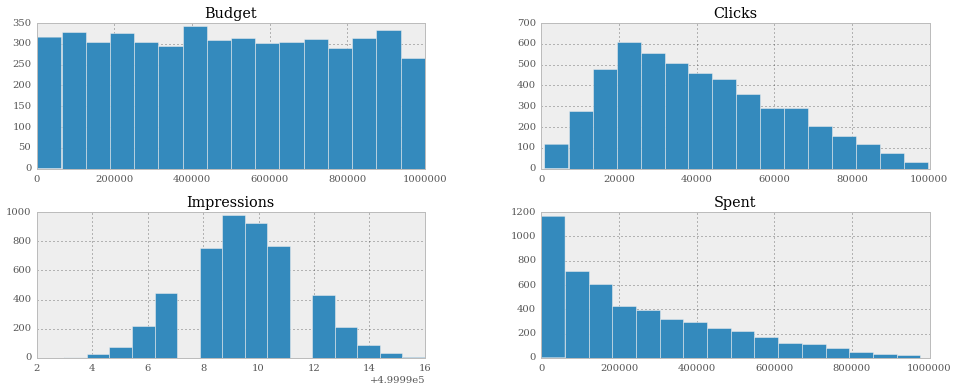

In [34]:
df[['Budget', 'Spent', 'Clicks', 'Impressions']].hist(
    bins=16, figsize=(16, 6));

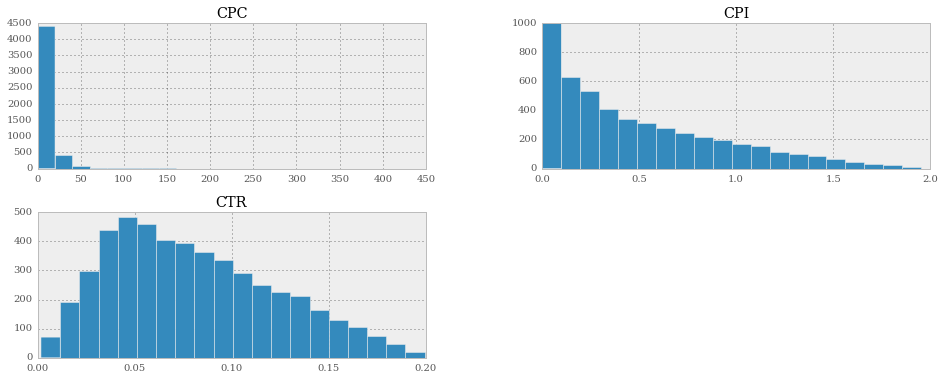

In [35]:
df[['CTR', 'CPC', 'CPI']].hist(
    bins=20, figsize=(16, 6));

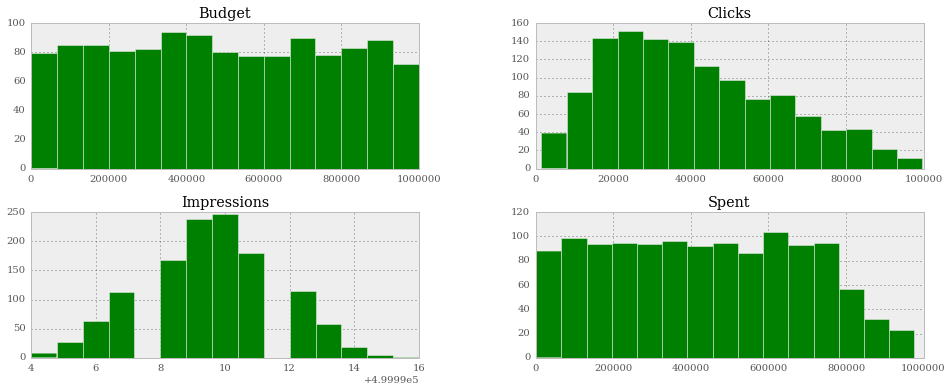

In [36]:
# let's see the campaigns whose spent is > than 75% of the budget
mask = (df.Spent > 0.75 * df.Budget)
df[mask][['Budget', 'Spent', 'Clicks', 'Impressions']].hist(
    bins=15, figsize=(16, 6), color='g');

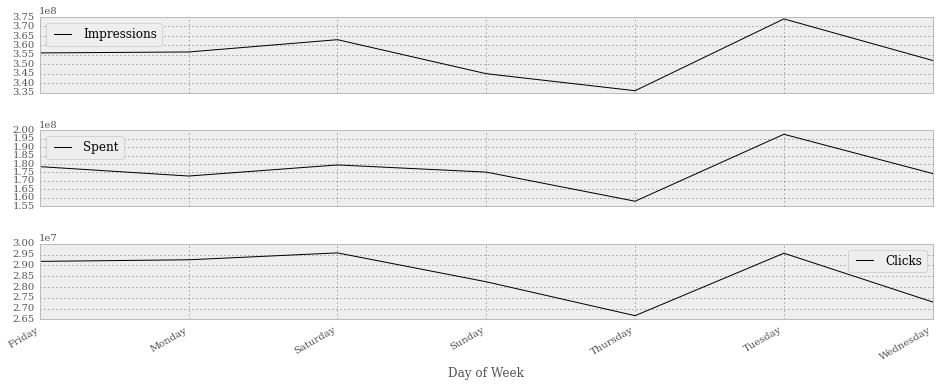

In [37]:
# Let's aggregate per Day of the Week
df_weekday = df.groupby(['Day of Week']).sum()
df_weekday[['Impressions', 'Spent', 'Clicks']].plot(
    figsize=(16, 6), subplots=True);

In [38]:
# Let's aggregate per gender
agg_config = {
    'Impressions': {
        'Mean Impr': 'mean',
        'Std Impr': 'std',
    },
    'Spent': ['mean', 'std'],
}

df.groupby(['Target Gender', 'Target Age']).agg(agg_config)

Impressions             Spent               
                           Mean Impr  Std Impr    mean            std
Target Gender Target Age                                             
B             20-25           499998  2.042563  288098  257633.488883
              20-30           499999  1.742422  231143  214732.329834
              20-35           499999  1.977603  261988  236844.478867
              20-40           500000  1.978141  249364  204250.877952
              20-45           500000  2.121320  259768  216996.568381
              25-30           499999  2.392435  269549  233471.626325
              25-35           499999  1.903943  228380  207353.860089
              25-40           499999  2.116826  224549  195254.848298
              25-45           499999  2.138925  269692  223954.413314
              25-50           499999  1.850156  195079  202982.757470
              30-35           499999  2.020834  276378  248231.758530
              30-40           499999  1.898338  275139  241881.824466
              30-45           499999  1.831100  215352  182707.326897
              30-50           499999  2.117607  242085  200920.739064
              30-55           499999  2.228749  162265  201820.915688
              35-40           499999  1.927248  213148  198734.354891
              35-45           499999  2.035384  307609  242592.912042
              35-50           499999  2.363315  265059  262319.007327
              35-55           499999  2.144720  222976  189638.642597
              35-60           499999  1.509231  160688  102245.847373
              40-45           499999  1.953709  287891  241250.754017
              40-50           499999  2.110240  232127  195477.896224
              40-55           499999  1.968491  265240  216925.125795
              40-60           499999  2.004373  204030  193519.143089
              40-65           500000  1.995829  245354  215540.874618
              45-50           499999  1.962142  224546  196833.167546
              45-55           499998  2.044827  190291  127771.929558
              45-60           499999  1.832251  186485  245688.088384
              45-65           500000  1.799471  296532  221852.453707
              45-70           500001  3.535534  172350  182658.409503
...                              ...       ...     ...            ...
M             20-25           499999  1.787574  274053  210747.392205
              20-30           499999  2.036802  215177  193607.255329
              20-35           499999  1.958571  265706  220898.884932
              20-40           499999  1.945030  202022  188571.546181
              20-45           499999  1.549193  215101  201612.057829
              25-30           499999  1.908430  262628  242376.499733
              25-35           499999  1.972956  270975  230460.298323
              25-40           499999  2.235728  199424  200256.297801
              25-45           499999  1.750540  277854  248497.741593
              25-50           500000  1.878673  240140  204737.623323
              30-35           499999  2.098787  246038  215934.650330
              30-40           499999  1.916675  207697  207421.698260
              30-45           499999  1.988981  299768  240529.528302
              30-50           499999  1.882970  276554  219648.142933
              30-55           499999  1.898042  281811  213626.145184
              35-40           499999  2.066463  198140  192561.934577
              35-45           499999  2.133487  257546  230322.556251
              35-50           499999  1.708801  236634  219842.297962
              35-55           499999  2.009962  265032  223969.616819
              35-60           499999  1.749830  290136  235805.583477
              40-45           499999  1.887004  268203  220987.644175
              40-50           499999  2.141405  229455  223114.154473
              40-55           499999  1.981267  212969  198846.628425
              40-60           49999

In [39]:
# finally, let's make a pivot table
pivot = df.pivot_table(
    values=['Impressions', 'Clicks', 'Spent'],
    index=['Target Age'],
    columns=['Target Gender'],
    aggfunc=np.sum
)
pivot

Impressions                       Clicks                    \
Target Gender           B         F         M        B        F        M   
Target Age                                                                 
20-25            23499951  37499967  35999973  2259538  3203571  2761751   
20-30            37499950  32999968  31999955  2985289  2681071  2440167   
20-35            34499998  37999971  45999935  3022059  2671447  3554265   
20-40            35000000  34999949  33999938  2748076  2853426  2843313   
20-45             6500000   6000003   4999998   443990   568490   304363   
25-30            36499976  31999957  47999952  2984397  2652499  3800532   
25-35            40499973  32999953  35499955  2970890  2656332  2800007   
25-40            42499949  37499978  36499936  3565066  2772652  2661576   
25-45            40499928  35999977  34999977  3281795  2623285  2854107   
25-50             6499992   6999987   9000000   579397   671570   639574   
30-35            47999954  39499967  39999961  3989778  3369942  3573373   
30-40            31499964  35999983  35499971  2354503  3284008  2683750   
30-45            31999961  36999945  38999976  2447297  2966458  2764636   
30-50            39499948  49499978  43499948  3180166  3804747  3448473   
30-55             8999992   5999989   6499994   710268   504951   558006   
35-40            31999952  46999923  37499970  2662022  3570803  3111956   
35-45            32499989  33999985  39499953  2495211  2846714  3257439   
35-50            33499995  45999974  37999962  2719774  4229022  2976024   
35-55            37999963  39999939  42999954  3132816  3227637  3743766   
35-60             4999995  10500003  10499996   259488   789710   776493   
40-45            34999962  42999957  42499961  2924224  3448415  3385744   
40-50            34499960  46999981  36499961  2975785  4559829  2668826   
40-55            37499938  34999959  36499990  2829150  2752685  3044855   
40-60            42999956  39499961  47999916  3564426  3318640  3628900   
40-65             8000006   6999982   4500013   748385   470024   289673   
45-50             7999994   6499987   8500002   570821   647273   690988   
45-55             6999975   6999994   8999990   573654   497818   762523   
45-60            10499991   4000000   6999985   779861   280583   576402   
45-65             7500005   4499989   6499999   609719   227509   385736   
45-70             1000003    999997   1999996   116195   107448    81267   

                  Spent                      
Target Gender         B         F         M  
Target Age                                   
20-25          13540606  15518020  19731849  
20-30          17335744  17289438  13771348  
20-35          18077227  21182832  24444954  
20-40          17455488  17059562  13737561  
20-45           3376991   2966268   2151017  
25-30          19677080  15511679  25212313  
25-35          18498825  18617628  19239285  
25-40          19086691  22192685  14557980  
25-45          21845127  19252504  19449819  
25-50           2536031   5022102   4322526  
30-35          26532367  19621771  19683082  
30-40          17333788  15931665  14746519  
30-45          13782557  17142840  23381937  
30-50          19124754  25757975  24060283  
30-55           2920777   2225594   3663544  
35-40          13641473  24054171  14860530  
35-45          19994585  20207137  20346181  
35-50          17758976  19290316  17984230  
35-55          16946233  19298599  22792755  
35-60           1606883   4602506   6092862  
40-45          20152414  21088594  22797289  
40-50          16016823  24166740  16750264  
40-55          19893013  15509495  15546809  
40-60          17546638  18168611  26269460  
40-65           3925679   3341906   2250840  
45-50           3592738   3673704   5006258  
45-55           2664082   3364330   4400680  
45-60           3916187   2319629   4601538  
45-65           4447985   1601035   3663507  
45-70            344700    105341